Kaggle Project Clean Version

* GridSearch with custom scoring
* Dimension reduction
* Composing different estmators

In [1]:
import numpy as np
import sklearn
%pylab inline

import math

from sklearn import linear_model
from sklearn import cross_validation
from sklearn import metrics
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import grid_search 
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import grid_search

scaler = preprocessing.StandardScaler()


Populating the interactive namespace from numpy and matplotlib


/Users/animato/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/animato/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


* Load the data


In [2]:
columns = range(2,14) # features being used. 

X = np.loadtxt('../kaggle/train.csv',  delimiter=',', 
               skiprows=1, usecols = columns) 

X_scaled = X_scaled = preprocessing.scale(X)

X_tags = np.loadtxt('../kaggle/train.csv',  delimiter=',', 
               skiprows=0, usecols = columns, dtype = 'bytes').astype('str')[0]

print(X_tags)

y = np.loadtxt('../kaggle/train.csv',  delimiter=',',  #cnt
               skiprows=1, usecols = [14])

# what we need to predict for the test : 

X_test = np.loadtxt('../kaggle/test.csv',  delimiter=',', 
               skiprows=1, usecols = columns) 

# the id of the moment ~ time. 

X_test_id = np.loadtxt('../kaggle/test.csv',  delimiter=',', 
               skiprows=1, usecols = [0], dtype = 'int') #no id no date 



['season' 'yr' 'mnth' 'hr' 'holiday' 'weekday' 'workingday' 'weathersit'
 'temp' 'atemp' 'hum' 'windspeed']


In [23]:
new_X = np.zeros((10886,13))
new_X[:,:-1] = X
for i in range(len(new_X[:,0])): 
    new_X[:,0] = np.cos(new_X[:,0]/4 *2*np.pi)
    new_X[:,12] = np.sin(new_X[:,0]/4 *2*np.pi) #season circles round

new_X_2 = np.zeros((10886,14))
new_X_2[:,:-1] = new_X
for i in range(len(new_X_2[:,0])): 
    new_X_2[:,2] = np.cos(new_X_2[:,0]/12 *2*np.pi)
    new_X_2[:,13] = np.sin(new_X_2[:,0]/12 *2*np.pi) #month circles round
print(new_X_2.shape)


new_X_3 = np.zeros((10886,15))
new_X_3[:,:-1] = new_X_2
for i in range(len(new_X_3[:,0])): 
    new_X_3[:,3] = np.cos(new_X_3[:,0]/24 *2*np.pi)
    new_X_3[:,13] = np.sin(new_X_3[:,0]/24 *2*np.pi) #hours circles round
print(new_X_3.shape)



new_X_t = np.zeros((6493,13))
new_X_t[:,:-1] = X_test
for i in range(len(new_X_t[:,0])): 
    new_X_t[:,0] = np.cos(new_X_t[:,0]/4 *2*np.pi)
    new_X_t[:,12] = np.sin(new_X_t[:,0]/4 *2*np.pi) #season circles round

new_X_2_t = np.zeros((6493,14))
new_X_2_t[:,:-1] = new_X_t
for i in range(len(new_X_2_t[:,0])): 
    new_X_2_t[:,2] = np.cos(new_X_2_t[:,0]/12 *2*np.pi)
    new_X_2_t[:,13] = np.sin(new_X_2_t[:,0]/12 *2*np.pi) #month circles round
print(new_X_2_t.shape)


new_X_3_t = np.zeros((6493,15))
new_X_3_t[:,:-1] = new_X_2_t
for i in range(len(new_X_3_t[:,0])): 
    new_X_3_t[:,3] = np.cos(new_X_3_t[:,0]/24 *2*np.pi)
    new_X_3_t[:,13] = np.sin(new_X_3_t[:,0]/24 *2*np.pi) #hours circles round
print(new_X_3_t.shape)



(10886, 14)
(10886, 15)
(6493, 14)
(6493, 15)


* How many features do you have? How are they encoded?


We have 12 features, some are in binary and others are normalized between 0 and 1

* Plot histograms to visualize the distribution of your features. Should you scale or normalize them?

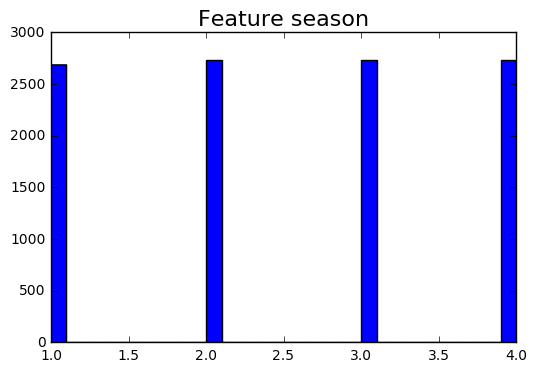

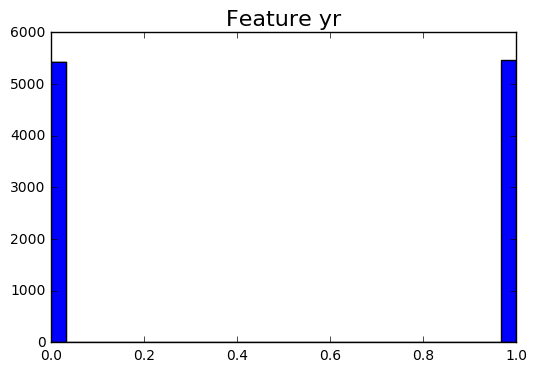

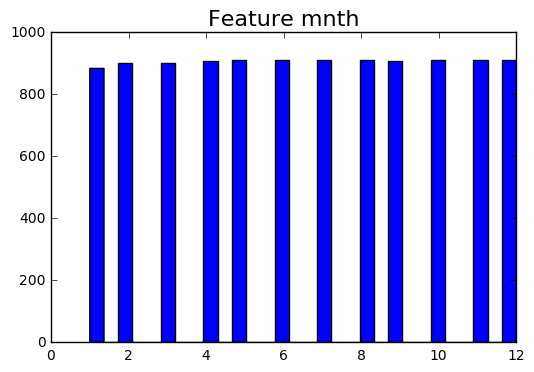

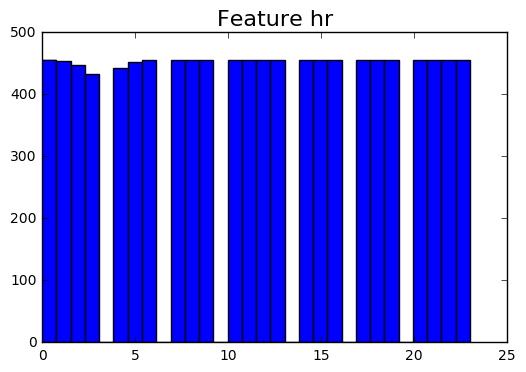

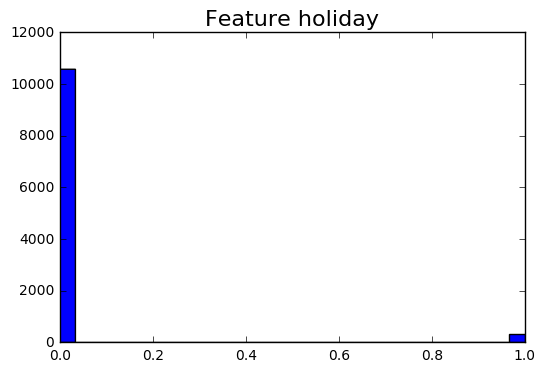

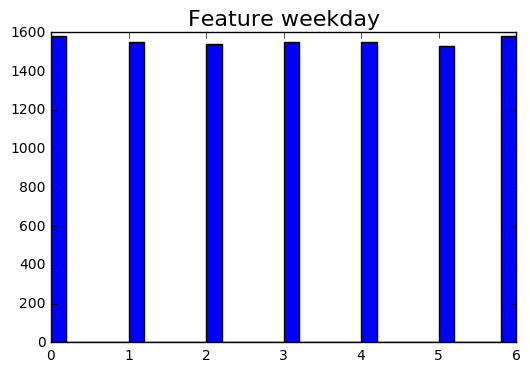

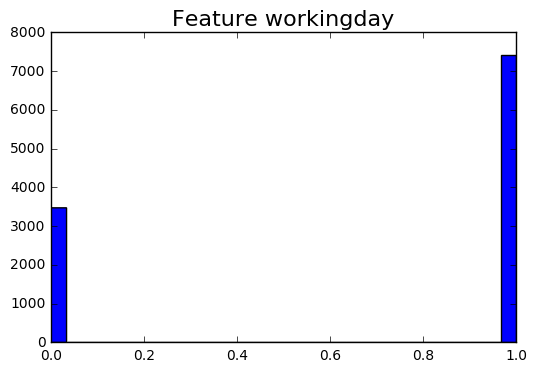

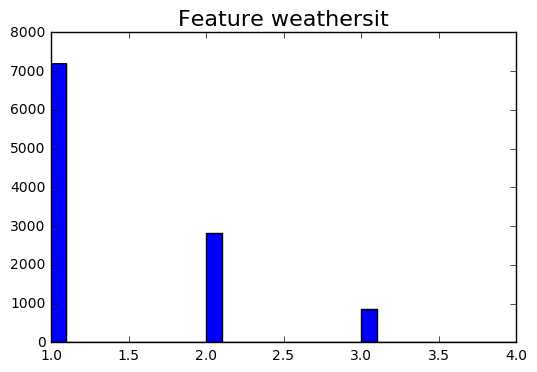

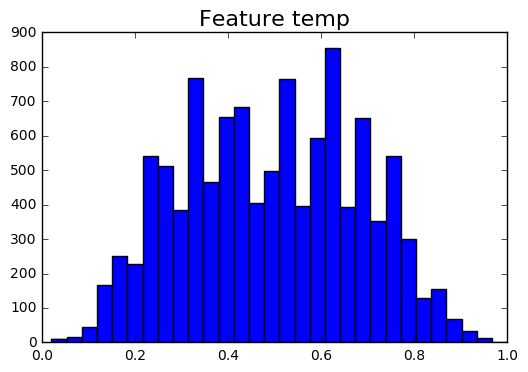

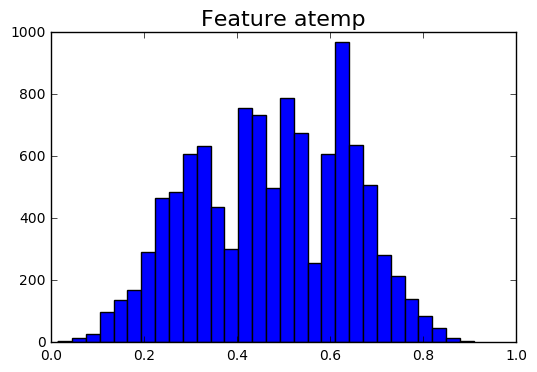

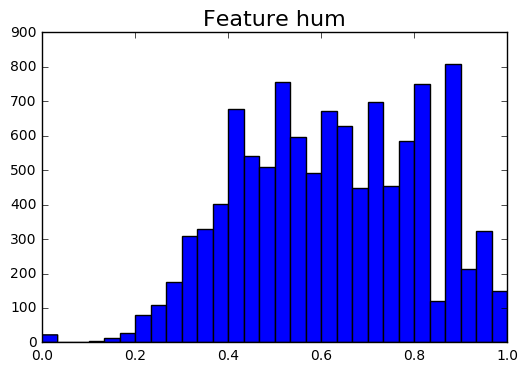

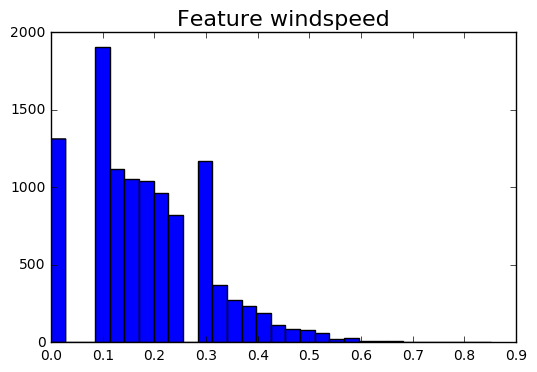

In [40]:
for i in range(len(columns)):
    plt.figure(i)
    #h = plt.hist(X[:, i], bins=30, color='blue')
    h2 = plt.hist(X[:, i], bins=30, color='blue')
    plt.title('Feature %s' % X_tags[i], fontsize=16)
    

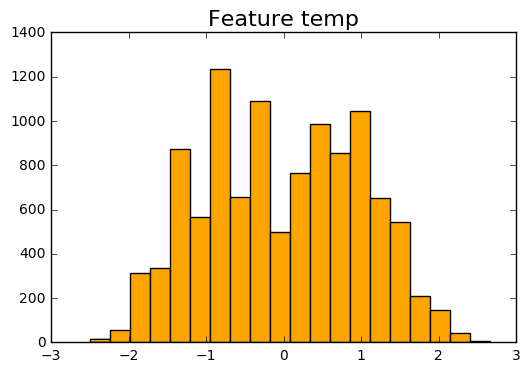

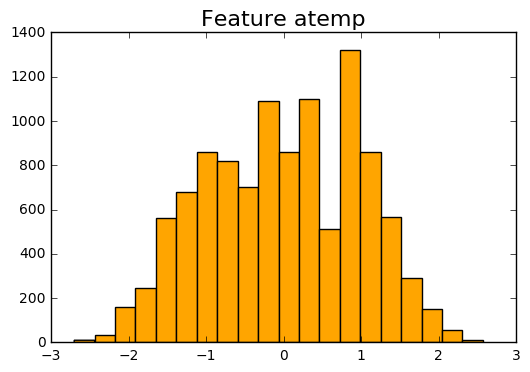

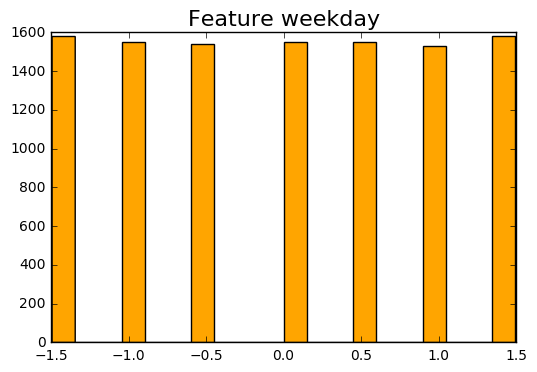

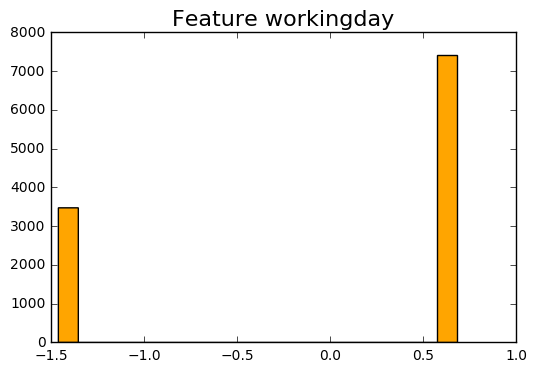

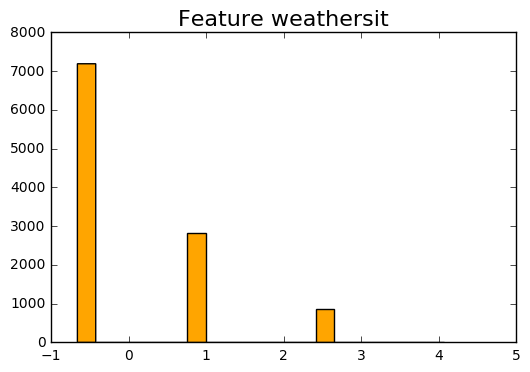

In [51]:
for i in range(5,10):
    plt.figure(i)
    #h = plt.hist(X[:, i], bins=30, color='blue')
    h2 = plt.hist(X_scaled[:, i], bins=20, color='orange')
    plt.title('Feature %s' % X_tags[i], fontsize=16)



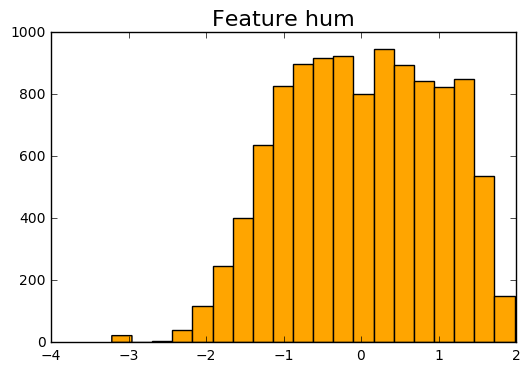

In [46]:
    plt.figure(10)
    #h = plt.hist(X[:, i], bins=30, color='blue')
    h2 = plt.hist(X_scaled[:, 10], bins=20, color='orange')
    plt.title('Feature %s' % X_tags[10], fontsize=16)


* Set up a cross-validation that you will use for all your evaluations. Notice there is a 'random_state' parameter to the cross-validation methods of scikit-learn, that you can use to ensure you always get the same splits. 


In [4]:
# bike prediction can't be < 0 nor > to max (900) : 
def compact(y_pred) :
    return y_pred.clip(min=0).clip(max = 900)

# define folds for cross validation
folds = cross_validation.KFold(10886, n_folds=10, shuffle=True)

def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    y_pred = compact(y_pred)
    #print([y_pred[i] + 1 for i,pred in enumerate(y_pred)])
    #print([y[i] + 1 for i,pred in enumerate(y_pred)])
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5
        

In [5]:
data_eval = metrics.make_scorer(rmsle)

In [6]:



def cross_validate_with_scaling(design_matrix, labels, classifier, cv_folds):
    
    #design_matrix = preprocessing.normalize(design_matrix)
    
    scaler = preprocessing.StandardScaler()
    
    pred = np.zeros(labels.shape)
    
    for tr, te in cv_folds:
        
        Xtr = scaler.fit_transform(design_matrix[tr])
        Xte = scaler.transform(design_matrix[te])
        classifier.fit(Xtr, labels[tr])
        pred.flat[te] = classifier.predict(Xte)
        
        
    #print(metrics.mean_squared_error(labels, compact(pred)))
    #print(metrics.accuracy_score(y, pred))
    #print(labels, compact(pred))

    print(rmsle(labels, compact(pred)))
    return compact(pred)


def cross_validate(design_matrix, labels, classifier, cv_folds):
    
    #design_matrix = preprocessing.normalize(design_matrix)
    
    pred = np.zeros(labels.shape)
    
    for tr, te in cv_folds:
        
        Xtr = design_matrix[tr]
        Xte = design_matrix[te]
        classifier.fit(Xtr, labels[tr])
        pred.flat[te] = classifier.predict(Xte)
        
        
    #print(metrics.mean_squared_error(labels, compact(pred)))
    #print(metrics.accuracy_score(y, pred))
    #print(labels, compact(pred))

    print(rmsle(labels, compact(pred)))
    return compact(pred)

* function to submit results

In [7]:
def submit(name, y_pred):
    my_sub = open(name + '.csv', 'w')

    my_sub.write('Id,Prediction\n')

    for i in range (len(y_pred)):
        my_sub.write('{},{}\n'.format(int(X_test_id[i]), int(y_pred[i])))

    my_sub.close()

def predict(X_test, X, y, classifier):
    classifier.fit(X,y)
    return classifier.predict(X_test)


def predict_scaled(X_test, X, y, classifier):
    scaler = preprocessing.StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_test_scaled = scaler.transform(X_test)
    classifier.fit(X_scaled,y)
    return classifier.predict(X_test_scaled)

* linear regression

In [8]:
y_pred_lin_reg = cross_validate(X,y,linear_model.LinearRegression(), folds)
y_pred_lin_reg_test = compact(predict(X_test, X, y, linear_model.LinearRegression()))
submit('lin_reg', y_pred_lin_reg_test)

1.30279553313


In [9]:
y_pred_lin_reg_n = cross_validate_with_scaling(X,y,linear_model.LinearRegression(normalize=True), folds)
y_pred_lin_reg_test_n = compact(predict(X_test, X, y, linear_model.LinearRegression(normalize=True)))
submit('lin_reg_normalized', y_pred_lin_reg_test_n)

1.30279553313


* lasso l1

In [10]:
y_pred_l1_lasso = cross_validate_with_scaling(X,y,linear_model.Lasso(alpha = 11), folds)
y_pred_l1_lasso_test = compact(predict(X_test, X, y, linear_model.Lasso(alpha = 11)))
submit('lasso_alpha_11', y_pred_l1_lasso_test )

#if we test with cos/sin the hours/season etc, we get 1.40905265035 (and the offical result gives  1.45133 which is even worse T_T)
#if we test without it we get 1.30143088542 with alpha = 0.1 : 1.34711 (in real submission)


#if alpha = 11 with submission : 1.32830 and we get 1.24224158936 (clearly overfitting)

1.24314190342


    * lasso l1 with gridSearch

In [11]:
parameters_lasso = {'alpha':np.arange(1,20,1)} #grid search doesn't make sense >.< 
grid_lasso = grid_search.GridSearchCV(linear_model.Lasso(), parameters_lasso, scoring=data_eval)
y_pred_l1_lasso_grid = cross_validate_with_scaling(X,y,grid_lasso, folds)
print(grid_lasso.best_estimator_)

1.2906681263
Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


* ridge l2

In [26]:
y_pred_l2_ridge = cross_validate_with_scaling(X,y,linear_model.Ridge(alpha = 0.1), folds)
y_pred_l2_ridge_test = compact(predict(X_test, X, y, linear_model.Ridge(alpha = 5)))
submit('ridge', y_pred_l2_ridge_test)

#grid search doesn't make any sense, it just chooses the minimum of alpha 
# if alpha = 5 : 1.30335063948 (us) and on the test set : (1.34903) overfitting much :'(

1.30279109836


* ridge with gridsearch l2

In [48]:
parameters_ridge = {'alpha':np.arange(0.05,1,0.05)}
grid_ridge = grid_search.GridSearchCV(linear_model.Ridge(), parameters_ridge)
y_pred_l2_ridge_grid = cross_validate_with_scaling(X,y,grid_ridge, folds)
y_pred_l2_ridge_test = compact(predict(X_test, X, y, grid_ridge))
submit('ridge', y_pred_l2_ridge_test)
print(grid_ridge.best_estimator_)

1.30275065064
Ridge(alpha=0.95000000000000007, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)


* ElasticNet

In [29]:
y_pred_elastic_net = cross_validate_with_scaling(X,y,linear_model.ElasticNet(alpha=0.1), folds)
y_pred_elastic_net_test = compact(predict(X_test, X, y, linear_model.ElasticNet(alpha = 0.1)))
submit('elasticNet', y_pred_elastic_net_test )

1.28844869519


In [35]:
parameters_elastic = {'alpha':np.arange(0.01,2,0.03)}
grid_elastic = grid_search.GridSearchCV(linear_model.ElasticNet(), parameters_elastic)
y_pred_l2_elastic_grid = cross_validate_with_scaling(X,y,grid_elastic, folds)
y_pred_elastic_net_test = compact(predict(X_test, X, y, grid_elastic))
submit('elasticNet', y_pred_elastic_net_test)
print(grid_elastic.best_estimator_)

1.28109751646
ElasticNet(alpha=0.040000000000000001, copy_X=True, fit_intercept=True,
      l1_ratio=0.5, max_iter=1000, normalize=False, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)


* LassoLars

In [28]:
y_pred_lasso_lars = cross_validate_with_scaling(X,y,linear_model.LassoLars(alpha=0.1), folds)
y_pred_lasso_lars_test = compact(predict(X_test, X, y, linear_model.LassoLars(alpha = 0.1)))
submit('lassoLars', y_pred_lasso_lars_test )

1.24505372569


* knn_regressor

In [17]:
y_pred_knn = cross_validate_with_scaling(X,y,neighbors.KNeighborsRegressor(n_neighbors=2), folds)
y_pred_knn_test = compact(predict(X_test, X, y, neighbors.KNeighborsRegressor(n_neighbors=2)))
submit('knn', y_pred_knn_test)

#y_pred_knn_test_scaled = compact(predict_scaled(X_test, X, y, neighbors.KNeighborsRegressor(n_neighbors=5)))
#submit('knn_scaled', y_pred_knn_test_scaled)
#scaling gives crappy results

0.8312797992


In [18]:
#y_pred_knn= cross_validate_with_scaling(X,y,neighbors.KNeighborsRegressor(n_neighbors=10, metric='euclidean'), folds)
#y_pred_knn= cross_validate_with_scaling(X,y,neighbors.KNeighborsRegressor(n_neighbors=10, metric='manhattan'), folds)
#y_pred_knn= cross_validate_with_scaling(X,y,neighbors.KNeighborsRegressor(n_neighbors=10, metric='chebyshev'), folds)

they suck cause the distances doesn't make any sense. 

* BaggingRegressor

In [30]:

parameters_bag = {'n_estimators':np.arange(15,25,1)}

bag_grid = grid_search.GridSearchCV(ensemble.BaggingRegressor(n_jobs=-1), parameters_bag)

y_pred_bag = cross_validate_with_scaling(X,y,bag_grid, folds)

#y_pred_bag_grid_test = compact(predict(X_test, X, y, ensemble.BaggingRegressor(n_jobs=-1, n_estimators = 30)))

#submit('bag_grid_maxfeat', y_pred_bag_grid_test)


0.336108191461


In [31]:


y_pred_ex = cross_validate_with_scaling(X,y,ensemble.ExtraTreesRegressor(), folds)

y_pred_ex_test = compact(predict(X_test, X, y, ensemble.ExtraTreesRegressor()))

submit('extra_trees', y_pred_ex_test)


0.335344497553


In [32]:

y_pred_grad = cross_validate_with_scaling(X,y,ensemble.GradientBoostingRegressor(), folds)

y_pred_grad_test = compact(predict(X_test, X, y, ensemble.GradientBoostingRegressor()))

submit('gradient_Boosting', y_pred_grad_test)

0.743781469716


In [18]:
print(bag_grid.best_estimator_)

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=24, n_jobs=-1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)


* Random Forest

In [25]:
rf = ensemble.RandomForestRegressor(n_estimators=12, n_jobs=-1)

y_pred_rf = cross_validate_with_scaling(X,y,rf, folds)
y_pred_rf_test = compact(predict(X_test, X, y, rf))
submit('rf', y_pred_rf_test)

0.333575794591


In [20]:
parameters_rf = {'n_estimators':np.arange(14,18,1), 'max_features':('sqrt','log2','auto',)}
rf_grid = grid_search.GridSearchCV(ensemble.RandomForestRegressor(), parameters_rf)
# , scoring=data_eval doesn't seem to yield good results
#y_pred_rf_grid = cross_validate_with_scaling(X,y,rf_grid, folds)
y_pred_rf_grid_test = compact(predict(X_test, X, y, rf_grid))
submit('rf_grid_maxfeat', y_pred_rf_grid_test)
# RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
#            max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
#            min_samples_split=2, min_weight_fraction_leaf=0.0,
#            n_estimators=14, n_jobs=1, oob_score=False, random_state=None,
#            verbose=0, warm_start=False)

In [21]:
print(rf_grid.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=16, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [22]:
# RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
#            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
#            min_samples_split=2, min_weight_fraction_leaf=0.0,
#            n_estimators=16, n_jobs=1, oob_score=False, random_state=None,
#            verbose=0, warm_start=False)

In [23]:
rf_grid.fit(X_scaled,y)
print(rf_grid.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=15, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


* svm regressor

In [26]:
y_pred_svm = cross_validate_with_scaling(X,y,svm.SVR(), folds)
y_pred_svm_test = compact(predict(X_test, X, y, svm.SVR()))
submit('svm', y_pred_knn_test)

1.04405430778


    * svm with gridSearch

In [ ]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_svm = dict(gamma=gamma_range, C=C_range)
#parameters_svm = {'C':np.arange(1.65,1.,0.1)}
#, gamma=0.0125, ,C=1.7
svm_grid = grid_search.GridSearchCV(svm.SVR(kernel='rbf', cache_size=7000, verbose=True), param_svm, scoring=data_eval)
# , scoring=data_eval doesn't seem to yield good results
svm_grid.fit(X,y)
y_pred_svm_grid_test = compact(svm_grid.predict(X_test))

submit('svm_grid_log', y_pred_svm_grid_test)

# y_pred_svm_grid_test = compact(predict(X_test, X, y, ensemble.RandomForestRegressor(n_estimators=16)))
# submit('rf_grid', y_pred_rf_grid_test)


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [125]:
print(svm_grid.best_estimator_)

# SVR(C=80.099999999999994, cache_size=100, coef0=0.0, degree=3, epsilon=0.1,
#   gamma=0.10000000000000001, kernel='rbf', max_iter=-1, shrinking=True,
#   tol=0.001, verbose=True)


# 0.80
# SVR(C=70, cache_size=100, coef0=0.0, degree=3, epsilon=0.1, gamma=0.31,
#   kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=True)


y_pred_svr_grid_test = compact(predict(X_test, X, y, svm.SVR(kernel='rbf', cache_size=100, verbose=True, gamma=0.31, C=80.1)))
submit('svr_grid', y_pred_svr_grid_test)

SVR(C=70, cache_size=100, coef0=0.0, degree=3, epsilon=0.1, gamma=0.31,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=True)
[LibSVM]

    * With specific linear kernel

In [91]:
parameters_linsvm = {'C': np.arange(0.1,1,0.2)}
linsvm_grid = grid_search.GridSearchCV(svm.LinearSVR(), parameters_linsvm)
# , scoring=data_eval doesn't seem to yield good results
y_pred_linsvm_grid = cross_validate_with_scaling(X,y,linsvm_grid, folds)
# y_pred_svm_grid_test = compact(predict(X_test, X, y, ensemble.RandomForestRegressor(n_estimators=16)))
# submit('rf_grid', y_pred_rf_grid_test)

1.23174770763


In [92]:
print(linsvm_grid.best_estimator_)

LinearSVR(C=0.90000000000000013, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)


* Kernel Ridge (kernel trick) 

In [28]:
from sklearn.kernel_ridge import KernelRidge


kr = grid_search.GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1),
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

y_pred_kr_grid = cross_validate_with_scaling(X,y,kr,folds)


KeyboardInterrupt: 

 * DecisionTreeRegressor(max_depth=5)

In [27]:
y_pred_tree = cross_validate_with_scaling(X,y,tree.DecisionTreeRegressor(max_depth=5), folds)
y_pred_tree_test = compact(predict(X_test, X, y, tree.DecisionTreeRegressor(max_depth=5)))
submit('tree_5', y_pred_tree_test)

0.610837740101


* MLP Regressor

In [17]:
from sklearn import neural_network

mlpR = neural_network.MLPRegressor(learning_rate='adaptive', activation = 'tanh', alpha=0.01, max_iter=300, solver='sgd')

y_pred_mlp = cross_validate_with_scaling(X,y,mlpR, folds)
y_pred_mlp_test = compact(predict(X_test, X, y, mlpR))
submit('mlp', y_pred_mlp_test)


0.746731065713


averaging between models

In [31]:
def averaging(arr):
    return np.mean(arr, axis=0)

In [32]:
y_average = averaging([y_pred_tree, y_pred_knn, y_pred_lin_reg])


print(rmsle(y_average, y))

0.891638323729


In [33]:
y_average = averaging([y_pred_l1_lasso, y_pred_knn, y_pred_lin_reg])
print(rmsle(y_average, y))

1.0702066484


In [34]:
y_average_test = averaging([y_pred_tree_test, y_pred_knn_test])
submit('averaging_test', y_average_test)